In [1]:
## This notebook contains all of the data preprocessing as proposed by Asmaa + visualidsationn 

## Import the libraries

In [226]:
import matplotlib.pylab as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import os
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sns.set()

## Load the raw data into the notebook

In [68]:
all_data_path = "data/"
#since the emails and the matches were split into two files, let's make them in a dataframe.
emails_pd = pd.concat([pd.read_csv("data/emails1.csv",index_col=0),pd.read_csv("data/emails2.csv",index_col=0)])
matches_pd = pd.concat([pd.read_csv("data/matches1.csv",index_col=0),pd.read_csv("data/matches2.csv",index_col=0),pd.read_csv("data/matches3.csv",index_col=0)])
#load the rest of the dataframes
answers_pd = pd.read_csv(os.path.join(all_data_path, 'answers.csv'))
answer_scores_pd = pd.read_csv(os.path.join(all_data_path, 'answer_scores.csv'))
comments_pd = pd.read_csv(os.path.join(all_data_path, 'comments.csv'))
groups_pd = pd.read_csv(os.path.join(all_data_path, 'groups.csv'))
group_memberships_pd = pd.read_csv(os.path.join(all_data_path, 'group_memberships.csv'))
professionals_pd = pd.read_csv(os.path.join(all_data_path, 'professionals.csv'))
questions_pd = pd.read_csv(os.path.join(all_data_path, 'questions.csv'))
question_scores_pd = pd.read_csv(os.path.join(all_data_path, 'question_scores.csv')) 
school_memberships_pd = pd.read_csv(os.path.join(all_data_path, 'school_memberships.csv'))
students_pd = pd.read_csv(os.path.join(all_data_path, 'students.csv'))
tags_pd = pd.read_csv(os.path.join(all_data_path, 'tags.csv'))
tag_questions_pd = pd.read_csv(os.path.join(all_data_path, 'tag_questions.csv'))
tag_users_pd = pd.read_csv(os.path.join(all_data_path, 'tag_users.csv'))

## Exploratory Data Analysis 

### 1. Visualise the connections among the dataframes

In [167]:
from graphviz import Digraph, Source

g = Digraph('G', filename='process.gv', engine='sfdp')

g.edge('Answers', 'Professionals')
g.edge('Questions', 'Answers')
g.edge('Question Score', 'Questions')
g.edge('Answer Score', 'Answers')
g.edge('Emails', 'Answers')
g.edge('Emails', 'Matches')
g.edge('Answers', 'Comments')
g.edge('Questions', 'Comments')
g.edge('Questions', 'Question Tags')
g.edge('Students', 'Group Memberships')
g.edge('Students', 'School Memberships')
g.edge('Tag Users', 'Group Memberships')
g.edge('Tag Users', 'Tags')
g.edge('Tag Questions', 'Tags')
g.edge('Questions', 'Tag Questions')
g.edge('Group Memberships', 'Groups')
g.edge('Matches', 'Questions')

s = Source(g, filename="data_flow", format="png")
s.view()

'data_flow.png'

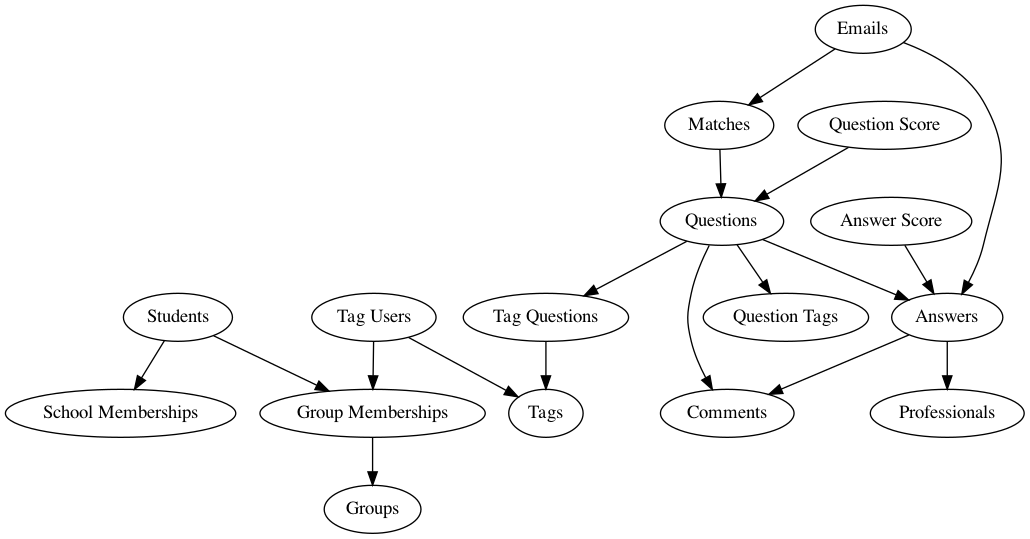

In [168]:
from IPython.display import display, Image
display(Image(filename='data_flow.png'))

### 2. Visualise each of the dataframes

In [172]:
answers_df['answers_date_added'] = pd.to_datetime(answers_pd['answers_date_added'], infer_datetime_format=True)
comments_pd['comments_date_added'] = pd.to_datetime(comments_pd['comments_date_added'], infer_datetime_format=True)
emails_pd['emails_date_sent'] = pd.to_datetime(emails_pd['emails_date_sent'], infer_datetime_format=True)
professionals_pd['professionals_date_joined'] = pd.to_datetime(professionals_pd['professionals_date_joined'], infer_datetime_format=True)
questions_pd['questions_date_added'] = pd.to_datetime(questions_pd['questions_date_added'], infer_datetime_format=True)
students_pd['students_date_joined'] = pd.to_datetime(students_pd['students_date_joined'], infer_datetime_format=True)

In [181]:
temp = answers_pd.groupby('answers_author_id')['answers_date_added'].max()
professionals_pd['date_last_answer'] = pd.merge(professionals_pd, pd.DataFrame(temp.rename('last_answer')), left_on='professionals_id', right_index=True, how='left')['last_answer']
# First Answer
temp = answers_pd.groupby('answers_author_id')['answers_date_added'].min()
professionals_pd['date_first_answer'] = pd.merge(professionals_pd, pd.DataFrame(temp.rename('first_answer')), left_on='professionals_id', right_index=True, how='left')['first_answer']
# Last Comment
temp = comments_pd.groupby('comments_author_id')['comments_date_added'].max()
professionals_pd['date_last_comment'] = pd.merge(professionals_pd, pd.DataFrame(temp.rename('last_comment')), left_on='professionals_id', right_index=True, how='left')['last_comment']
# First Comment
temp = comments_pd.groupby('comments_author_id')['comments_date_added'].min()
professionals_pd['date_first_comment'] = pd.merge(professionals_pd, pd.DataFrame(temp.rename('first_comment')), left_on='professionals_id', right_index=True, how='left')['first_comment']
# Last Activity
professionals_pd['date_last_activity'] = professionals_pd[['date_last_answer', 'date_last_comment']].max(axis=1)
# First Activity
professionals_pd['date_first_activity'] = professionals_pd[['date_first_answer', 'date_first_comment']].min(axis=1)

# Laslt activity (Question)
temp = questions_pd.groupby('questions_author_id')['questions_date_added'].max()
students_pd['date_last_question'] = pd.merge(students_pd, pd.DataFrame(temp.rename('last_question')), left_on='students_id', right_index=True, how='left')['last_question']
# First activity (Question)
temp = questions_pd.groupby('questions_author_id')['questions_date_added'].min()
students_pd['date_first_question'] = pd.merge(students_pd, pd.DataFrame(temp.rename('first_question')), left_on='students_id', right_index=True, how='left')['first_question']
# Last activity (Comment)
temp = comments_pd.groupby('comments_author_id')['comments_date_added'].max()
students_pd['date_last_comment'] = pd.merge(students_pd, pd.DataFrame(temp.rename('last_comment')), left_on='students_id', right_index=True, how='left')['last_comment']
# First activity (Comment)
temp = comments_pd.groupby('comments_author_id')['comments_date_added'].min()
students_pd['date_first_comment'] = pd.merge(students_pd, pd.DataFrame(temp.rename('first_comment')), left_on='students_id', right_index=True, how='left')['first_comment']
# Last activity (Total)
students_pd['date_last_activity'] = students_pd[['date_last_question', 'date_last_comment']].max(axis=1)
# First activity (Total)
students_pd['date_first_activity'] = students_pd[['date_first_question', 'date_first_comment']].min(axis=1)

In [183]:
pro_emails_pd = pd.merge(professionals_pd, emails_pd, how='inner', left_on='professionals_id', right_on='emails_recipient_id')
pro_emails_pd = pro_emails_pd[pro_emails_pd['emails_frequency_level'] == 'email_notification_immediate']
pro_emails_pd = pro_emails_pd[['professionals_id', 'emails_id', 'emails_date_sent']]
pro_email_ques_pd = pro_emails_pd.merge(matches_pd, left_on='emails_id', right_on='matches_email_id')
pro_email_ques_pd = pro_email_ques_pd.drop(columns=['emails_id', 'matches_email_id']) \
                 .set_index('professionals_id').rename(columns={'matches_question_id': 'questions_id'})

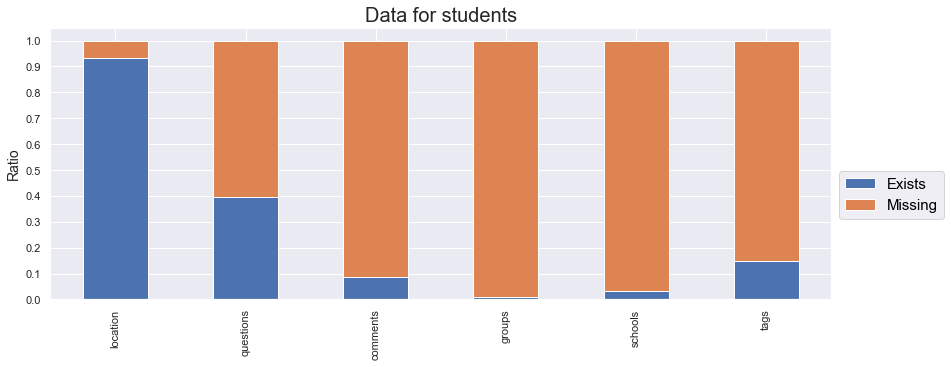

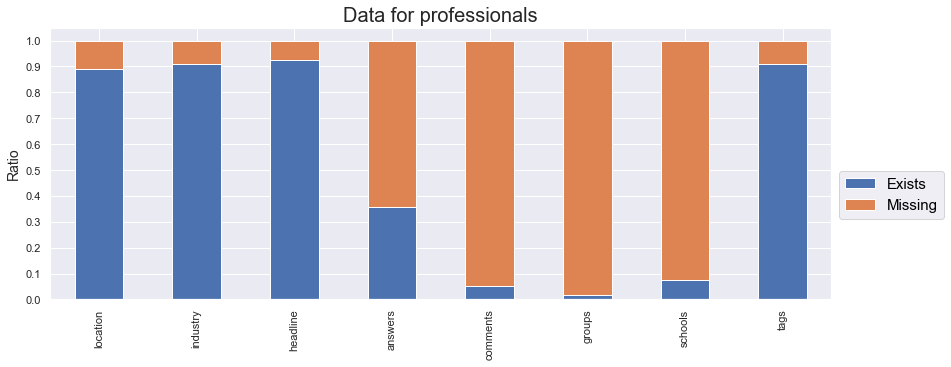

In [194]:
exists = 'Exists'
miss = 'Missing'

fields = {
    'students': {
        'df': students_pd,
        'features': ['location'],
        'count': {
            'questions': questions_pd,
            'comments': comments_pd
        },
        'memberships': {
            'groups': group_memberships_pd,
            'schools': school_memberships_pd
        },
        'plts': {}
    },
    'professionals': {
        'df': professionals_pd,
        'features': ['location', 'industry', 'headline'],
        'count': {
            'answers': answers_pd,
            'comments': comments_pd
        },
        'memberships': {
            'groups': group_memberships_pd,
            'schools': school_memberships_pd
        },
        'plts': {} 
    }
}

for user in fields.keys():
    user_spec = fields[user]
    
    df = user_spec['df']
    
    tmp = df[['{}_{}'.format(user, feature) for feature in user_spec['features']]]
    tmp = tmp.fillna(miss)
    tmp[tmp != miss] = exists 

    for feature in user_spec['features']:
        user_spec['plts'][feature] = tmp.groupby('{}_{}'.format(user, feature)).size()/len(tmp)
    
    # Counts
    for key, cdf in user_spec['count'].items():
        tf = cdf.groupby('{}_author_id'.format(key)).size()
        tf['counts'] = pd.merge(df, pd.DataFrame(tf.rename('count')), left_on='{}_id'.format(user), right_index=True, how='left')['count'].fillna(0).astype(int)
        
        tf = tf['counts']
        tf[tf > 0] = exists
        tf[tf != exists] = miss
        
        user_spec['plts'][key] = tf.groupby(tf.values).size()/len(tf)

    # Counts
    for key, mdf in user_spec['memberships'].items():
        unique_userid_with_membership = mdf['{}_memberships_user_id'.format(key[:-1])].unique()
        tf = pd.DataFrame()
        tf['val'] = df['{}_id'.format(user)]
        
        tf[tf['val'].isin(unique_userid_with_membership)] = exists
        tf[tf['val'] != exists] = miss

        user_spec['plts'][key] = tf.groupby('val').size()/len(tf)
        
    # Tags
    unique_user_ids_with_tags = tag_users_pd['tag_users_user_id'].unique()
    tf = pd.DataFrame()
    tf['val'] = df['{}_id'.format(user)]
    
    tf[tf['val'].isin(unique_user_ids_with_tags)] = exists
    tf[tf['val'] != exists] = miss
    
    user_spec['plts']['tags'] = tf.groupby('val').size()/len(tf)
    plt_data = pd.DataFrame(user_spec['plts'])
    
    plt_data.T.plot(kind='bar', stacked=True, figsize=(14, 5))
    plt.ylabel('Ratio', fontsize=14)
    plt.title('Data for {}'.format(user), fontsize=20)
    plt.yticks(np.arange(0, 1.05, 0.1))
    leg = plt.legend(bbox_to_anchor=(1, 0.5), fontsize=15)
    for text in leg.get_texts():
        plt.setp(text, color = 'black')
    plt.show()

In [201]:
import pandas as pd 
import missingno as msno 


In [230]:
students_df = pd.concat([students_pd,questions_pd,comments_pd, group_memberships_pd,school_memberships_pd])
professionals_df = pd.concat([professionals_pd,answers_pd,comments_pd, group_memberships_pd])

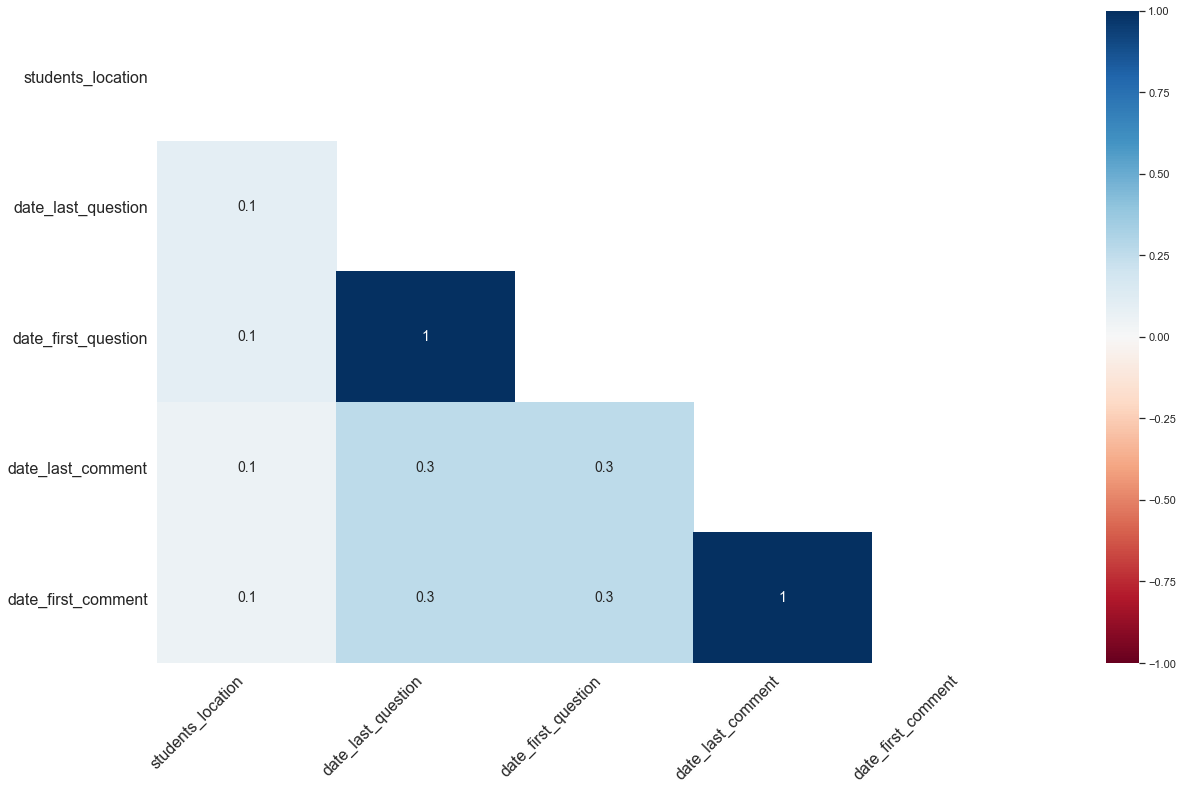

In [214]:
msno.heatmap(students_pd) 


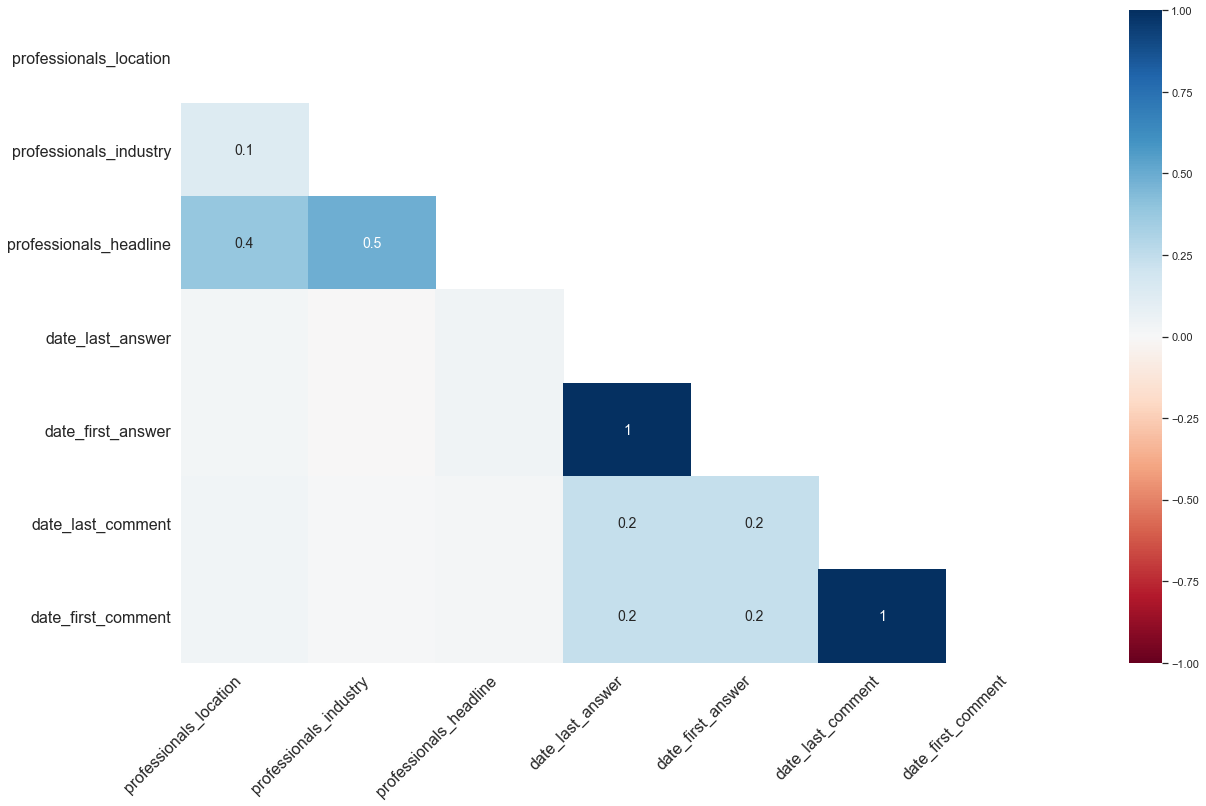

In [215]:
msno.heatmap(professionals_pd) 


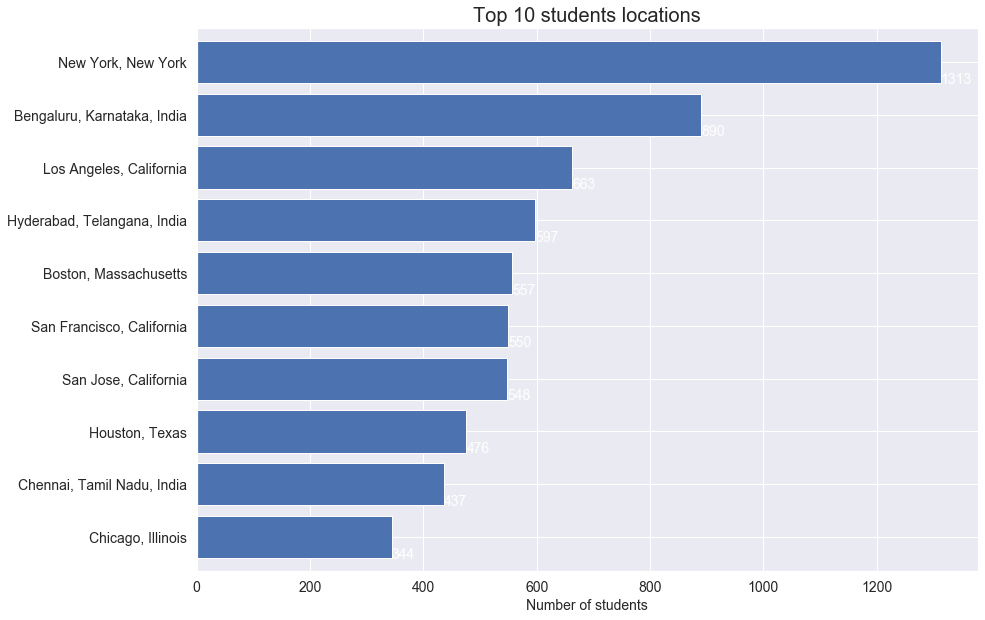

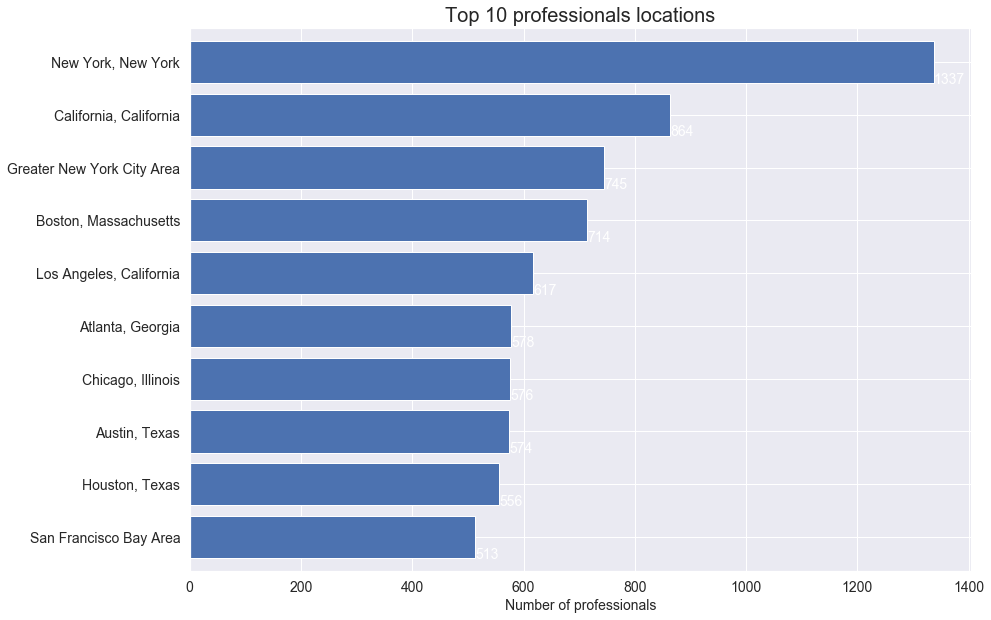

In [227]:
n_locations = 10

users = [
    ('students', students_pd),
    ('professionals', professionals_pd)
]

for user, df in users:
    locations = df['{}_location'.format(user)].value_counts().sort_values(ascending=True).tail(n_locations)
    
    ax = locations.plot(kind='barh',figsize=(14, 10),width=0.8, fontsize=14) 
    ax.set_title('Top %s {} locations'.format(user) % n_locations, fontsize=20)
    ax.set_xlabel('Number of {}'.format(user), fontsize=14)
    for p in ax.patches:
        ax.annotate(str(p.get_width()), (p.get_width(), p.get_y()), color='w', fontsize=14)
    plt.show()
    

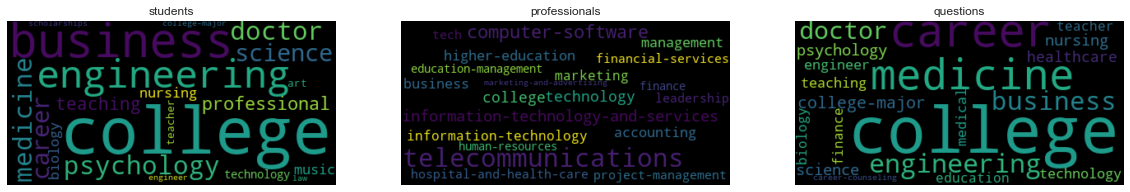

In [229]:
entities = [
    ('students', students_pd),
    ('professionals', professionals_pd),
    ('questions', questions_pd)
]

dfs = []

for entity, df in entities:
    if entity == 'questions':
        df = tag_questions_pd
        df = pd.merge(df, tags_pd, left_on='tag_questions_tag_id', right_on='tags_tag_id')
    else:
        df = tag_users_pd[tag_users_pd['tag_users_user_id'].isin(df['{}_id'.format(entity)])]
        df = pd.merge(df, tags_pd, left_on='tag_users_tag_id', right_on='tags_tag_id')

    df['entity_type'] = entity

    dfs.append(df)


plt_data = pd.concat(dfs)
plt_data = plt_data[['tags_tag_name', 'entity_type']].pivot_table(index='tags_tag_name', columns='entity_type', aggfunc=len, fill_value=0)

for entity, df in entities:
    plt_data[entity] = plt_data[entity] / len(df)

plt_data['sum'] = (plt_data['professionals'] + plt_data['students'] + plt_data['questions'])
plt_data = plt_data.sort_values(by='sum', ascending=False).drop(['sum'], axis=1).head(100)


# Wordcloud
plt.figure(figsize=(20, 20))
wordloud_values = ['students', 'professionals', 'questions']
axisNum = 1
for wordcloud_value in wordloud_values:
    wordcloud = WordCloud(margin=0, max_words=20, random_state=42).generate_from_frequencies(plt_data[wordcloud_value])
    ax = plt.subplot(1, 3, axisNum)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(wordcloud_value)
    plt.axis("off")
    axisNum += 1
plt.show()    

Cosine Similarity --> the Similarity in tags of questions, answers, and tags